In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

In [2]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.24.1', 'qiskit-aer': '0.12.1', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.20.2', 'qiskit': '0.43.2', 'qiskit-nature': '0.6.2', 'qiskit-finance': '0.3.4', 'qiskit-optimization': '0.5.0', 'qiskit-machine-learning': '0.6.1'}

In [3]:
from IPython.display import IFrame
IFrame("https://www.youtube.com/embed/hOlOY7NyMfs?start=75&end=126",560,315)

In [4]:
# Brute force period finding algorithm
def find_period_classical(x, N):
    n = 1
    t = x
    while t != 1:
        t *= x
        t %= N
        n += 1
    return n

In [5]:
import random, itertools

# Sieve of Eratosthenes algorithm
def sieve( ):
    D = {  }
    yield 2
    for q in itertools.islice(itertools.count(3), 0, None, 2):
        p = D.pop(q, None)
        if p is None:
            D[q*q] = q
            yield q
        else:
            x = p + q
            while x in D or not (x&1):
                x += p
            D[x] = p

# Creates a list of prime numbers up to the given argument
def get_primes_sieve(n):
    return list(itertools.takewhile(lambda p: p<n, sieve()))

def get_semiprime(n):
    primes = get_primes_sieve(n)
    l = len(primes)
    p = primes[random.randrange(l)]
    q = primes[random.randrange(l)]
    return p*q

N = get_semiprime(1000)

print("semiprime N =",N)

semiprime N = 91657


In [6]:
import math

def shors_algorithm_classical(N):
    x = random.randint(0,N) # step one
    if(math.gcd(x,N) != 1): # step two
        return x,0,math.gcd(x,N),N/math.gcd(x,N)
    r = find_period_classical(x,N) # step three
    while(r % 2 != 0):
        r = find_period_classical(x,N)
    p = math.gcd(x**int(r/2)+1,N) # step four, ignoring the case where (x^(r/2) +/- 1) is a multiple of N
    q = math.gcd(x**int(r/2)-1,N)
    return x,r,p,q

x,r,p,q = shors_algorithm_classical(N)
print("semiprime N = ",N,", coprime x = ",x,", period r = ",r,", prime factors = ",p," and ",q,sep="")

semiprime N = 91657, coprime x = 88668, period r = 15150, prime factors = 607 and 151


In [7]:
from qiskit import BasicAer, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.tools.visualization import plot_histogram

In [8]:
# qc = quantum circuit, qr = quantum register, cr = classical register, a = 2, 7, 8, 11 or 13
def circuit_amod15(qc,qr,cr,a):
    if a == 2:
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[1],qr[0])
    elif a == 7:
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])
    elif a == 8:
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[3],qr[2])
    elif a == 11: # this is included for completeness
        qc.cswap(qr[4],qr[2],qr[0])
        qc.cswap(qr[4],qr[3],qr[1])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])
    elif a == 13:
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])

In [17]:
# qc = quantum circuit, qr = quantum register, cr = classical register, a = 2, 7, 8, 11 or 13
def circuit_aperiod15(qc,qr,cr,a):
    if a == 11:
        circuit_11period15(qc,qr,cr)
        return
    
    # Initialize q[0] to |1> 
    qc.x(qr[0])

    # Apply a**4 mod 15
    qc.h(qr[4])
    #   controlled identity on the remaining 4 qubits, which is equivalent to doing nothing
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[0])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply a**2 mod 15
    qc.h(qr[4])
    #   controlled unitary
    qc.cx(qr[4],qr[2])
    qc.cx(qr[4],qr[0])
    #   feed forward
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[1])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply a mod 15
    qc.h(qr[4])
    #   controlled unitary.
    circuit_amod15(qc,qr,cr,a)
    #   feed forward
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[2])

In [18]:
def circuit_11period15(qc,qr,cr):
    # Initialize q[0] to |1> 
    qc.x(qr[0])

    # Apply a**4 mod 15
    qc.h(qr[4])
    #   controlled identity on the remaining 4 qubits, which is equivalent to doing nothing
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[0])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply a**2 mod 15
    qc.h(qr[4])
    #   controlled identity on the remaining 4 qubits, which is equivalent to doing nothing
    #   feed forward
    qc.u1(math.pi/2.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[1])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply 11 mod 15
    qc.h(qr[4])
    #   controlled unitary.
    qc.cx(qr[4],qr[3])
    qc.cx(qr[4],qr[1])
    #   feed forward
    qc.u1(3.*math.pi/4.,qr[4]).c_if(cr, 3)
    qc.u1(math.pi/2.,qr[4]).c_if(cr, 2)
    qc.u1(math.pi/4.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[2])

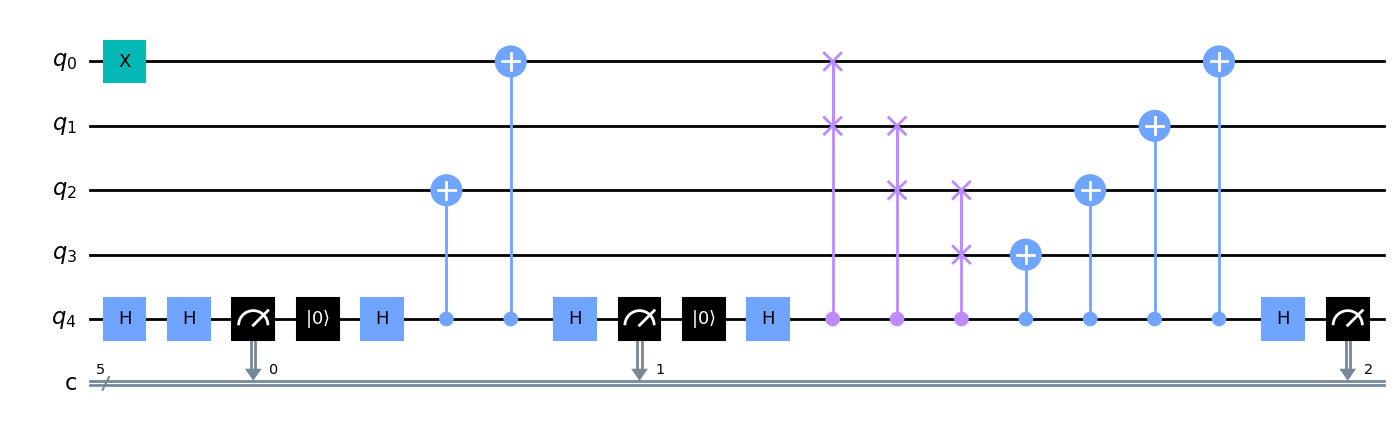

In [19]:
q = QuantumRegister(5, 'q')
c = ClassicalRegister(5, 'c')

shor = QuantumCircuit(q, c)
circuit_aperiod15(shor,q,c,7)
shor.draw(output='mpl')

In [ ]:
# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, execute, Aer, IBMQ
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
import matplotlib.pyplot as plt

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

from qiskit.providers.ibmq import least_busy
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 and
not x.configuration().simulator and x.status().operational==True)) # Find the least busy QC

#backend = BasicAer.get_backend('qasm_simulator')
sim_job = execute([shor], backend)
sim_result = sim_job.result()
sim_data = sim_result.get_counts(shor) 
plot_histogram(sim_data)

ibmqfactory.load_account:WARNING:2023-08-03 15:13:35,849: Credentials are already in use. The existing account in the session will be replaced.
